# Decoding ImageNet TFRecords with Nvidia DALI

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
list_of_files = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/*'))
indexes = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/idx_files/validation/*'))
list_of_files[:2], indexes[:2], len(list_of_files), len(indexes)

(['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00000-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00001-of-00128'],
 ['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/idx_files/validation/validation-00000-of-00128.idx',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/idx_files/validation/validation-00001-of-00128.idx'],
 128,
 128)

## Index files

Generated with Nvidia DALI's `tfrecord2idx` script. <br>
Contain location and sizes of each data sample in the TFrecord (image+labels).

In [3]:
!head -n10 {indexes[0]}
!wc {indexes[0]}

0 109822
109822 140592
250414 122956
373370 85181
458551 130636
589187 151692
740879 166159
907038 107719
1014757 115004
1129761 142638
 391  782 6050 /scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/idx_files/validation/validation-00000-of-00128.idx


In [4]:
# Total images in validation set
!cat {" ".join(indexes)} | wc -l
n_images = 50000

50000


## DALI loader for PyTorch

In [5]:
%%writefile dali_pt_dataloader.py
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec

# ImageNet1k statistics
IMAGENET_STATS = dict(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    std=[0.229 * 255, 0.224 * 255, 0.225 * 255],
)

def dali_dataloader(
        tfrec_filenames,
        tfrec_idx_filenames,
        shard_id=0,
        num_shards=1,
        batch_size=128,
        num_threads=4,
        resize=256,
        crop=224,
        prefetch=20,
        training=True,
        gpu_aug=False,
        gpu_out=False,
        device_id=0):
    pipe = Pipeline(batch_size=batch_size,
                    num_threads=num_threads,
                    device_id=device_id if gpu_aug or gpu_out else None)
    with pipe:
        # read tfrecords, return dict(feature=TensorList/DataNode)
        inputs = fn.readers.tfrecord(
            name='Reader',
            path=tfrec_filenames,
            index_path=tfrec_idx_filenames,
            features={
                'image/encoded': tfrec.FixedLenFeature((), tfrec.string, ""),
                'image/class/label': tfrec.FixedLenFeature([1], tfrec.int64,  -1),
            },
            # sharding
            shard_id=shard_id,
            num_shards=num_shards,
            # shuffling
            random_shuffle=training,
            initial_fill=10000,
            # prefetch
            read_ahead=True,
            prefetch_queue_depth=prefetch)

        # get images
        jpegs = inputs["image/encoded"]
        decode_device = "mixed" if gpu_aug else "cpu"
        resize_device = "gpu" if gpu_aug else "cpu"

        if training:
            # decode jpeg and random crop
            images = fn.decoders.image_random_crop(jpegs,
                use_fast_idct=True,
                device=decode_device,
                output_type=types.RGB,
                random_aspect_ratio=[crop/resize, resize/crop],
                random_area=[crop/resize, 1.0],
                num_attempts=100,
                # ask HW NVJPEG to allocate memory ahead for the biggest image in the data set to avoid reallocations in runtime
                preallocate_width_hint=5980 if gpu_aug else 0,
                preallocate_height_hint=6430 if gpu_aug else 0)
            images = fn.resize(images,
                               device=resize_device,
                               resize_x=resize,
                               resize_y=resize,
                               dtype=types.FLOAT,
                               interp_type=types.INTERP_TRIANGULAR)

            # additional training transforms
            images = fn.rotate(images,
                               angle=fn.random.uniform(range=(-30, 30)),
                               keep_size=True,
                               fill_value=0)
            images = fn.noise.gaussian(images, stddev=20)
            # ... https://docs.nvidia.com/deeplearning/dali/user-guide/docs/supported_ops.html

            flip_lr = fn.random.coin_flip(probability=0.5)
        else:
            # decode jpeg and resize; caching supported
            images = fn.decoders.image(jpegs,
                                       device=decode_device,
                                       use_fast_idct=True,
                                       output_type=types.RGB,
                                      )
            images = fn.resize(images,
                               device=resize_device,
                               resize_shorter=crop,
                               dtype=types.FLOAT,
                               interp_type=types.INTERP_TRIANGULAR)
            flip_lr = False

        # center crop and normalise
        images = fn.crop_mirror_normalize(images,
                                          crop=(crop, crop),
                                          mean=IMAGENET_STATS['mean'],
                                          std=IMAGENET_STATS['std'],
                                          output_layout="CHW",
                                          mirror=flip_lr)
        label = inputs["image/class/label"] - 1  # 0-999
        if gpu_out or gpu_aug:  # transfer data to gpu
            pipe.set_outputs(images.gpu(), label.gpu())
        else:
            pipe.set_outputs(images, label)

    pipe.build()
    loader = DALIClassificationIterator(
        pipe,
        reader_name="Reader",
        last_batch_padded=False,
        auto_reset=True,
        last_batch_policy=LastBatchPolicy.DROP if training else LastBatchPolicy.PARTIAL,
    )
    return loader


Overwriting dali_pt_dataloader.py


In [6]:
from dali_pt_dataloader import dali_dataloader

batch_size = 8
num_shards = 64 # world size
shard_id = 0    # rank

train_loader = dali_dataloader(
    batch_size=batch_size,
    num_threads=12,
    tfrec_filenames=list_of_files,
    tfrec_idx_filenames=indexes,
    shard_id=shard_id,
    num_shards=num_shards,
    gpu_aug=True,
    gpu_out=True,
    training=False,
)

print(len(train_loader), len(train_loader)*batch_size*num_shards)

98 50176


In [7]:
n = 0
first = None

for (data,) in tqdm(train_loader):
    images, target = data['data'], data['label'].ravel()
    n += len(target)
    if first is None:
        first = data

print(n, data.keys(), images.shape, target.shape)

assert n == (n_images//num_shards) or n == np.ceil(n_images/num_shards)

  0%|          | 0/98 [00:00<?, ?it/s]

781 dict_keys(['data', 'label']) torch.Size([5, 3, 224, 224]) torch.Size([5])


## Last batch

In [8]:
images.shape, images.min(), images.max(), images.mean(), images.std(), target

(torch.Size([5, 3, 224, 224]),
 tensor(-2.1179, device='cuda:0'),
 tensor(2.6400, device='cuda:0'),
 tensor(0.0069, device='cuda:0'),
 tensor(1.1126, device='cuda:0'),
 tensor([526, 839, 299, 578, 112], device='cuda:0'))

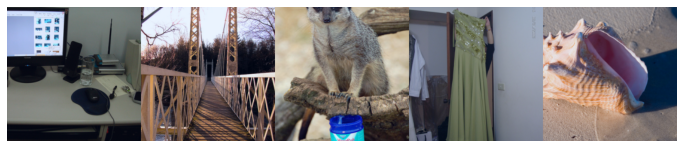

In [9]:
concat = np.concatenate(images.permute(0,2,3,1).tolist(), 1)

# denorm
concat -= concat.min()
concat /= concat.max()

fig, ax = plt.subplots(figsize=(12, 3))
plt.imshow(concat)
plt.axis('off')
plt.show()

## First batch

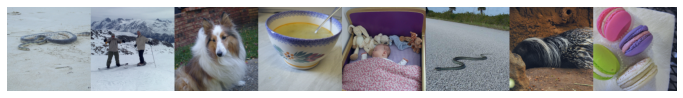

In [10]:
concat = np.concatenate(first['data'].permute(0,2,3,1).tolist(), 1)

# denorm
concat -= concat.min()
concat /= concat.max()

fig, ax = plt.subplots(figsize=(12, 3))
plt.imshow(concat)
plt.axis('off')
plt.show()